# **Segment with unet**


 [Source to code](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/notebooks/vision-background-removal/vision-background-removal.ipynb)
(6.8.2024)

Mount

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import platform

%pip install -q "openvino>=2023.1.0"
%pip install -q --extra-index-url https://download.pytorch.org/whl/cpu "torch>=2.1" opencv-python
%pip install -q "gdown<4.6.4"

if platform.system() != "Windows":
    %pip install -q "matplotlib>=3.4"
else:
    %pip install -q "matplotlib>=3.4,<3.7"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 53.6 MB/s eta 0:00:00


In [3]:
import os
import time
from collections import namedtuple
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import openvino as ov
import torch
from IPython.display import HTML, FileLink, display

In [4]:
# Import local modules
import requests

if not Path("./notebook_utils.py").exists():
    # Fetch `notebook_utils` module

    r = requests.get(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
    )

    open("notebook_utils.py", "w").write(r.text)

from notebook_utils import load_image, download_file

if not Path("./model/u2net.py").exists():
    download_file(
        url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/vision-background-removal/model/u2net.py", directory="model"
    )
from model.u2net import U2NET, U2NETP

model/u2net.py:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

In [5]:
model_config = namedtuple("ModelConfig", ["name", "url", "model", "model_args"])

u2net_lite = model_config(
    name="u2net_lite",
    url="https://drive.google.com/uc?id=1W8E4FHIlTVstfRkYmNOjbr0VDXTZm0jD",
    model=U2NETP,
    model_args=(),
)
u2net = model_config(
    name="u2net",
    url="https://drive.google.com/uc?id=1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ",
    model=U2NET,
    model_args=(3, 1),
)
u2net_human_seg = model_config(
    name="u2net_human_seg",
    url="https://drive.google.com/uc?id=1m_Kgs91b21gayc2XLW0ou8yugAIadWVP",
    model=U2NET,
    model_args=(3, 1),
)

# Set u2net_model to one of the three configurations listed above.
u2net_model = u2net_lite

In [6]:
# The filenames of the downloaded and converted models.
MODEL_DIR = "model"
model_path = Path(MODEL_DIR) / u2net_model.name / Path(u2net_model.name).with_suffix(".pth")

Load the U-Net Model

In [7]:
if not model_path.exists():
    import gdown

    os.makedirs(name=model_path.parent, exist_ok=True)
    print("Start downloading model weights file... ")
    with open(model_path, "wb") as model_file:
        gdown.download(url=u2net_model.url, output=model_file)
        print(f"Model weights have been downloaded to {model_path}")

Start downloading model weights file... 


Downloading...
From: https://drive.google.com/uc?id=1W8E4FHIlTVstfRkYmNOjbr0VDXTZm0jD
To: <_io.BufferedWriter name='model/u2net_lite/u2net_lite.pth'>
100%|██████████| 4.68M/4.68M [00:00<00:00, 188MB/s]

Model weights have been downloaded to model/u2net_lite/u2net_lite.pth


In [8]:
# Load the model.
net = u2net_model.model(*u2net_model.model_args)
net.eval()

# Load the weights.
print(f"Loading model weights from: '{model_path}'")
net.load_state_dict(state_dict=torch.load(model_path, map_location="cpu"))

Loading model weights from: 'model/u2net_lite/u2net_lite.pth'


<ipython-input-8-680a975f2088>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(state_dict=torch.load(model_path, map_location="cpu"))


<All keys matched successfully>

Convert PyTorch U-Net model to OpenVINO IR

In [9]:
model_ir = ov.convert_model(net, example_input=torch.zeros((1, 3, 512, 512)), input=([1, 3, 512, 512]))

/content/model/u2net.py:23: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  src = F.upsample(src,size=tar.shape[2:],mode='bilinear')


# Load and Pre-Process Input Image

In [15]:

IMAGE_URI = "/content/drive/Othercomputers/My PC/Thesis/raw_data/20240830/raw data/RGB/1D3A0818.JPG"

input_mean = np.array([123.675, 116.28, 103.53]).reshape(1, 3, 1, 1)
input_scale = np.array([58.395, 57.12, 57.375]).reshape(1, 3, 1, 1)

image = cv2.cvtColor(
    src=load_image(IMAGE_URI),
    code=cv2.COLOR_BGR2RGB,
)

resized_image = cv2.resize(src=image, dsize=(512, 512))
# Convert the image shape to a shape and a data type expected by the network
# for OpenVINO IR model: (1, 3, 512, 512).
input_image = np.expand_dims(np.transpose(resized_image, (2, 0, 1)), 0)

input_image = (input_image - input_mean) / input_scale

Select inference device

In [12]:
import ipywidgets as widgets

core = ov.Core()
device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value="AUTO",
    description="Device:",
    disabled=False,
)

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

Do Inference on OpenVINO IR Model

In [16]:
core = ov.Core()
# Load the network to OpenVINO Runtime.
compiled_model_ir = core.compile_model(model=model_ir, device_name=device.value)
# Get the names of input and output layers.
input_layer_ir = compiled_model_ir.input(0)
output_layer_ir = compiled_model_ir.output(0)

# Do inference on the input image.
start_time = time.perf_counter()
result = compiled_model_ir([input_image])[output_layer_ir]
end_time = time.perf_counter()
print(f"Inference finished. Inference time: {end_time-start_time:.3f} seconds, " f"FPS: {1/(end_time-start_time):.2f}.")

Inference finished. Inference time: 0.659 seconds, FPS: 1.52.


 Visualize Results

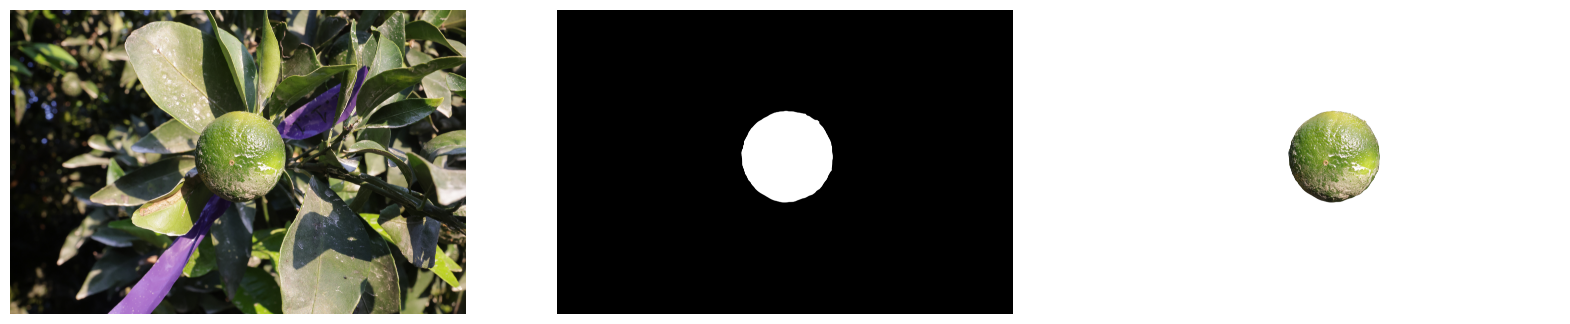

In [17]:
# Resize the network result to the image shape and round the values
# to 0 (background) and 1 (foreground).
# The network result has (1,1,512,512) shape. The `np.squeeze` function converts this to (512, 512).
resized_result = np.rint(cv2.resize(src=np.squeeze(result), dsize=(image.shape[1], image.shape[0]))).astype(np.uint8)

# Create a copy of the image and set all background values to 255 (white).
bg_removed_result = image.copy()
bg_removed_result[resized_result == 0] = 255

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 7))
ax[0].imshow(image)
ax[1].imshow(resized_result, cmap="gray")
ax[2].imshow(bg_removed_result)
for a in ax:
    a.axis("off")

In [ ]:
# Save the background-removed image to the specified directory
target_dir = '/content/drive/Othercomputers/My PC/Thesis/roboflowV6_1169/unet'
os.makedirs(target_dir, exist_ok=True)
output_path = os.path.join(target_dir, 'bg_removed_result.png')
cv2.imwrite(output_path, cv2.cvtColor(bg_removed_result, cv2.COLOR_RGB2BGR))
print(f"Image saved to {output_path}")

Image saved to /content/drive/Othercomputers/My PC/Thesis/roboflowV6_1169/unet/bg_removed_result.png


### **Run the code and save results**

In [14]:
# Function to process and save images
def process_and_save_images(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    for img_filename in os.listdir(input_dir):
        img_path = os.path.join(input_dir, img_filename)

        # Load and preprocess the image
        input_mean = np.array([123.675, 116.28, 103.53]).reshape(1, 3, 1, 1)
        input_scale = np.array([58.395, 57.12, 57.375]).reshape(1, 3, 1, 1)
        image = cv2.cvtColor(src=load_image(img_path), code=cv2.COLOR_BGR2RGB)
        resized_image = cv2.resize(src=image, dsize=(512, 512))
        input_image = np.expand_dims(np.transpose(resized_image, (2, 0, 1)), 0)
        input_image = (input_image - input_mean) / input_scale

        # Do inference
        core = ov.Core()
        compiled_model_ir = core.compile_model(model=model_ir, device_name="AUTO")
        input_layer_ir = compiled_model_ir.input(0)
        output_layer_ir = compiled_model_ir.output(0)
        result = compiled_model_ir([input_image])[output_layer_ir]

        # Post-process the result
        resized_result = np.rint(cv2.resize(src=np.squeeze(result), dsize=(image.shape[1], image.shape[0]))).astype(np.uint8)
        bg_removed_result = image.copy()
        bg_removed_result[resized_result == 0] = 255

        # Save the result
        output_path = os.path.join(output_dir, img_filename)
        cv2.imwrite(output_path, cv2.cvtColor(bg_removed_result, cv2.COLOR_RGB2BGR))
        print(f"Image saved to {output_path}")

RGB Paths

In [ ]:
# Directories to process
input_dirs = [
    '/content/drive/Othercomputers/My PC/Thesis/raw_data/20230825/Prediction/RGB',
    '/content/drive/Othercomputers/My PC/Thesis/raw_data/20230929/prediction/raw data/RGB',
    '/content/drive/Othercomputers/My PC/Thesis/raw_data/20231103/prediction/raw data/RGB',
    '/content/drive/Othercomputers/My PC/Thesis/raw_data/20231216/prediction/raw data/RGB'
]
output_base_dir = '/content/drive/Othercomputers/My PC/Thesis/roboflowV6_1169/unet'

In [ ]:
# Process each directory
for input_dir in input_dirs:
    date_str = os.path.basename(os.path.dirname(os.path.dirname(input_dir)))
    output_dir = os.path.join(output_base_dir, date_str)
    process_and_save_images(input_dir, output_dir)

Image saved to /content/drive/Othercomputers/My PC/Thesis/roboflowV6_1169/unet/20230825/1D3A3148.JPG
Image saved to /content/drive/Othercomputers/My PC/Thesis/roboflowV6_1169/unet/20230825/1D3A3149.JPG
Image saved to /content/drive/Othercomputers/My PC/Thesis/roboflowV6_1169/unet/20230825/1D3A3150.JPG
Image saved to /content/drive/Othercomputers/My PC/Thesis/roboflowV6_1169/unet/20230825/1D3A3151.JPG
Image saved to /content/drive/Othercomputers/My PC/Thesis/roboflowV6_1169/unet/20230825/1D3A3152.JPG
Image saved to /content/drive/Othercomputers/My PC/Thesis/roboflowV6_1169/unet/20230825/1D3A3153.JPG
Image saved to /content/drive/Othercomputers/My PC/Thesis/roboflowV6_1169/unet/20230825/1D3A3154.JPG
Image saved to /content/drive/Othercomputers/My PC/Thesis/roboflowV6_1169/unet/20230825/1D3A3155.JPG
Image saved to /content/drive/Othercomputers/My PC/Thesis/roboflowV6_1169/unet/20230825/1D3A3156.JPG
Image saved to /content/drive/Othercomputers/My PC/Thesis/roboflowV6_1169/unet/20230825/1D3

# Thermal

convert MAT to tiff

In [19]:
import numpy as np
import os
from scipy.io import loadmat
from PIL import Image

def mat_to_tiff(source_folder, destination_folder):
    # Ensure the destination folder exists
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
        print(f"Created directory: {destination_folder}")

    # List all MAT files in the source directory
    for file in os.listdir(source_folder):
        if file.endswith(".MAT") or file.endswith(".mat"):
            mat_file_path = os.path.join(source_folder, file)
            tiff_file_path = os.path.join(destination_folder, file.replace('.MAT', '.tiff').replace('.mat', '.tiff'))

            # Load the .mat file
            mat_data = loadmat(mat_file_path)

            # Extract the data key from the file name
            data_key = file.split('.')[0]

            # Access the specific data stored under the file name key
            if data_key in mat_data:
                image_data = mat_data[data_key]

                # Convert the data to an image
                if image_data.dtype != np.uint8:
                    image_data = (255 * (image_data - np.min(image_data)) / np.ptp(image_data)).astype(np.uint8)

                # Create an image from the numpy array
                image = Image.fromarray(image_data)

                # Save the image as TIFF
                image.save(tiff_file_path, format='TIFF')
                print(f"Converted {mat_file_path} to {tiff_file_path}")
            else:
                print(f"Data key '{data_key}' not found in {mat_file_path}")

# Usage
source_folder = '/content/drive/Othercomputers/My PC/Thesis/raw_data/20240830/raw data/Thermal MAT'
destination_folder = '/content/drive/Othercomputers/My PC/Thesis/raw_data/20240830/raw data/tiff'

# Call the function
mat_to_tiff(source_folder, destination_folder)


Converted /content/drive/Othercomputers/My PC/Thesis/raw_data/20240830/raw data/Thermal MAT/IR_30082024_0050.MAT to /content/drive/Othercomputers/My PC/Thesis/raw_data/20240830/raw data/tiff/IR_30082024_0050.tiff
Converted /content/drive/Othercomputers/My PC/Thesis/raw_data/20240830/raw data/Thermal MAT/IR_30082024_0051.MAT to /content/drive/Othercomputers/My PC/Thesis/raw_data/20240830/raw data/tiff/IR_30082024_0051.tiff
Converted /content/drive/Othercomputers/My PC/Thesis/raw_data/20240830/raw data/Thermal MAT/IR_30082024_0055.MAT to /content/drive/Othercomputers/My PC/Thesis/raw_data/20240830/raw data/tiff/IR_30082024_0055.tiff
Converted /content/drive/Othercomputers/My PC/Thesis/raw_data/20240830/raw data/Thermal MAT/IR_30082024_0067.MAT to /content/drive/Othercomputers/My PC/Thesis/raw_data/20240830/raw data/tiff/IR_30082024_0067.tiff
Converted /content/drive/Othercomputers/My PC/Thesis/raw_data/20240830/raw data/Thermal MAT/IR_30082024_0056.MAT to /content/drive/Othercomputers/My

rescaled Thermal paths

In [ ]:
import os

# Directories to process
input_dirs = [
   # '/content/drive/Othercomputers/My PC/Thesis/raw_data/20230825/Prediction/tiff',
   # '/content/drive/Othercomputers/My PC/Thesis/raw_data/20231103/prediction/raw data/tiff',
   # '/content/drive/Othercomputers/My PC/Thesis/raw_data/20230929/prediction/raw data/tiff',
   # '/content/drive/Othercomputers/My PC/Thesis/raw_data/20231216/prediction/raw data/tiff',
    '/content/drive/Othercomputers/My PC/Thesis/raw_data/20240830/raw data/tiff'

]

# Output directories, mapped by the same index as input_dirs
output_dirs = [
   # '/content/drive/Othercomputers/My PC/Thesis/roboflowV6_1169/unet/tiff/20230825',
   # '/content/drive/Othercomputers/My PC/Thesis/roboflowV6_1169/unet/tiff/20231103',
   # '/content/drive/Othercomputers/My PC/Thesis/roboflowV6_1169/unet/tiff/20230929',
   # '/content/drive/Othercomputers/My PC/Thesis/roboflowV6_1169/unet/tiff/20231216',
    '/content/drive/Othercomputers/My PC/Thesis/roboflowV6_1169/unet/tiff/20240830'
]

# Process each directory
for input_dir, output_dir in zip(input_dirs, output_dirs):
    process_and_save_images(input_dir, output_dir)


Image saved to /content/drive/Othercomputers/My PC/Thesis/roboflowV6_1169/unet/tiff/20240830/IR_30082024_0050.tiff
Image saved to /content/drive/Othercomputers/My PC/Thesis/roboflowV6_1169/unet/tiff/20240830/IR_30082024_0051.tiff
Image saved to /content/drive/Othercomputers/My PC/Thesis/roboflowV6_1169/unet/tiff/20240830/IR_30082024_0055.tiff
Image saved to /content/drive/Othercomputers/My PC/Thesis/roboflowV6_1169/unet/tiff/20240830/IR_30082024_0067.tiff
Image saved to /content/drive/Othercomputers/My PC/Thesis/roboflowV6_1169/unet/tiff/20240830/IR_30082024_0056.tiff
Image saved to /content/drive/Othercomputers/My PC/Thesis/roboflowV6_1169/unet/tiff/20240830/IR_30082024_0052.tiff
Image saved to /content/drive/Othercomputers/My PC/Thesis/roboflowV6_1169/unet/tiff/20240830/IR_30082024_0059.tiff
Image saved to /content/drive/Othercomputers/My PC/Thesis/roboflowV6_1169/unet/tiff/20240830/IR_30082024_0080.tiff
Image saved to /content/drive/Othercomputers/My PC/Thesis/roboflowV6_1169/unet/t